In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import librosa
import pickle
from tqdm import tqdm_notebook as tqdm
%matplotlib inline

In [2]:
import keras
from keras.layers import Input, Dense, Dropout
from keras.models import Model
from keras.optimizers import Adam
from keras.regularizers import l1, l2
from livelossplot import PlotLossesKeras

Using TensorFlow backend.


# Tempo prediction with NN

In [3]:
%run ../Utilities/Utilities.ipynb

In [4]:
data = pd.read_pickle("../Data/Guitar/bpm-data.pkl")

In [5]:
X_train, y_train, X_val, y_val, X_test, y_test = split_data(data, "bpm")

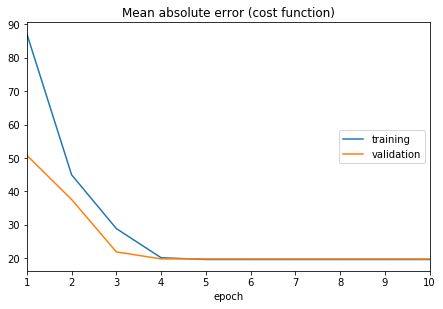

Mean absolute error (cost function):
training   (min:   19.591, max:   87.188, cur:   19.591)
validation (min:   19.753, max:   50.793, cur:   19.753)


In [6]:
inputs = Input(shape=(8,))
hidden1 = Dense(16, activation="relu")(inputs)
preds = Dense(1)(hidden1)

model = Model(inputs=inputs, outputs=preds)
sgd = keras.optimizers.Adam(lr=0.0005)
model.compile(optimizer=sgd, loss='mean_absolute_error')
history = model.fit(X_train, y_train, batch_size=None, epochs=10, verbose=0,
                    validation_data=(X_val, y_val),
                    callbacks=[PlotLossesKeras()])

Testing...

In [66]:
model.predict(pd.DataFrame({
    "d0": [0.475],
    "d1": [0.28125],
    "d2": [0.5125],
    "d3": [0.21875],
    "d4": [0.28125],
    "d5": [0.275],
    "d6": [0.45625],
    "d7": [0.15625]
}))

array([[129.61372]], dtype=float32)

Now let's compare it with the bpm estimation used until now

In [12]:
%run ../Pipeline/Sheet_generator.ipynb

In [13]:
SG = sheet_generator("../Single_note_models/Guitar/Guitar", "../Single_note_models/Guitar/Guitar_norm_string")

In [57]:
from sklearn.metrics import mean_absolute_error

In [62]:
preds = []
for index, row in tqdm(data.drop("bpm", axis=1).iterrows(), total = data.shape[0]):
    # Because of how the bpm method expects data...
    temp = np.zeros(shape=(8,3))
    temp[:,2] = row.values
    estimation = SG.bpm_estimation(temp)
    preds.append(estimation)

In [65]:
mean_absolute_error(data["bpm"].values, preds)

34.16686230248307

The NN performs better

In [68]:
temp = np.zeros(shape=(8,3))
temp[:,2] = [0.475, 0.28125, 0.5125, 0.21875,0.28125,0.275,0.45625,0.15625]
SG.bpm_estimation(temp)

110.0

Using the mean of both predictions

In [98]:
preds = []
for index, row in tqdm(data.drop("bpm", axis=1).iterrows(), total = data.shape[0]):
    # Because of how the bpm method expects data...
    temp = np.zeros(shape=(8,3))
    temp[:,2] = row.values
    estimation = np.mean([SG.bpm_estimation(temp), 
                          model.predict(pd.DataFrame({row.keys().values[i]: [row.values[i]] for i in range(8)}))[0][0]])
    preds.append(estimation)

In [99]:
mean_absolute_error(data["bpm"].values, preds)

24.438683854972087

Still performs than the NN alone